SARIMA MODEL:

In [149]:
# import yahoo finance data
import yfinance as yf
# import stockstats data 
from stockstats import StockDataFrame as ss

# import necessary libraries
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import pandas_gbq
import statsmodels
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

#import libraries for SARIMA model
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from datetime import date

In [150]:
apple_ticker = yf.Ticker("AAPL")
apple_data = yf.download("BTC-USD", start = '2020-01-01', end = '2024-02-01', interval = '1d')
apple_df = ss.retype(apple_data)

apple_data[['stochrsi', 'macd', 'mfi']] = apple_df[['stochrsi', 'macd', 'mfi']]
print(apple_data)
print(apple_ticker.get_capital_gains)

[*********************100%%**********************]  1 of 1 completed
                    open          high           low         close  \
Date                                                                 
2020-01-01   7194.892090   7254.330566   7174.944336   7200.174316   
2020-01-02   7202.551270   7212.155273   6935.270020   6985.470215   
2020-01-03   6984.428711   7413.715332   6914.996094   7344.884277   
2020-01-04   7345.375488   7427.385742   7309.514160   7410.656738   
2020-01-05   7410.451660   7544.497070   7400.535645   7411.317383   
...                  ...           ...           ...           ...   
2024-01-27  41815.625000  42195.632812  41431.281250  42120.054688   
2024-01-28  42126.125000  42797.175781  41696.910156  42035.593750   
2024-01-29  42030.914062  43305.867188  41818.332031  43288.246094   
2024-01-30  43300.226562  43838.945312  42711.371094  42952.609375   
2024-01-31  42946.250000  43717.406250  42298.945312  42582.605469   

               adj c

In [151]:
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    'black-vehicle-406619-bf2e31773163.json')
project_id = 'black-vehicle-406619'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = 'stocks_ds'
table_id = '20yrs_stockdata'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(apple_data, table_path, job_config=load_info)
load_data.result()

LoadJob<project=black-vehicle-406619, location=US, id=edabeaae-f6c4-44fe-8c1a-fffe128f1cdd>

In [152]:
#Seasonal - fit stepwise auto-ARIMA
#!pip install pmdarima

# Remove any duplicate index
apple_data = apple_data.loc[~apple_data.index.duplicated(keep='first')]

#Filter only required data

apple_data = apple_data[['close']]

In [153]:
#Scale the APPL data into a standard range using MinMaxScaler ()

Feature_Scaler = MinMaxScaler()

#Transform current APPL data

apple_transformed = pd.DataFrame(np.squeeze(Feature_Scaler.fit_transform(apple_data), axis=1), columns=["Close"], index=apple_data.index)


In [154]:

# Set the maximum duration for the model fitting process in seconds
max_duration = 900  # 15 minutes

start_time = time.time()

sarima_model = pm.auto_arima(apple_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequency of the cycle (yearly)
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
                         
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

# start_p=1, start_q=1: Sets the initial values for the order of the AR (AutoRegressive) and MA (Moving Average) components in the non-seasonal part of the model.
# test='adf': Specifies the use of the Augmented Dickey-Fuller (ADF) test to determine whether the time series is stationary and to help in determining the need for differencing (`d` parameter).
# max_p=3, max_q=3: Specifies the maximum values for the `p` and `q` parameters to consider during the model fitting process.
# start_P=0: Sets the initial value for the order of the seasonal AR component.
# d=None: The order of non-seasonal differencing is not specified, which allows the function to determine it automatically.
# trace=False: This means that the function will not print out diagnostic information about the steps it's taking.
# error_action='ignore': Instructs the function to ignore errors and try different combinations of parameters.
# suppress_warnings=True: Suppresses convergence warnings, which can be frequent in ARIMA modeling.
# stepwise=True: Enables a stepwise search to efficiently find the best model parameters.

Elapsed time: 378.78486824035645 seconds


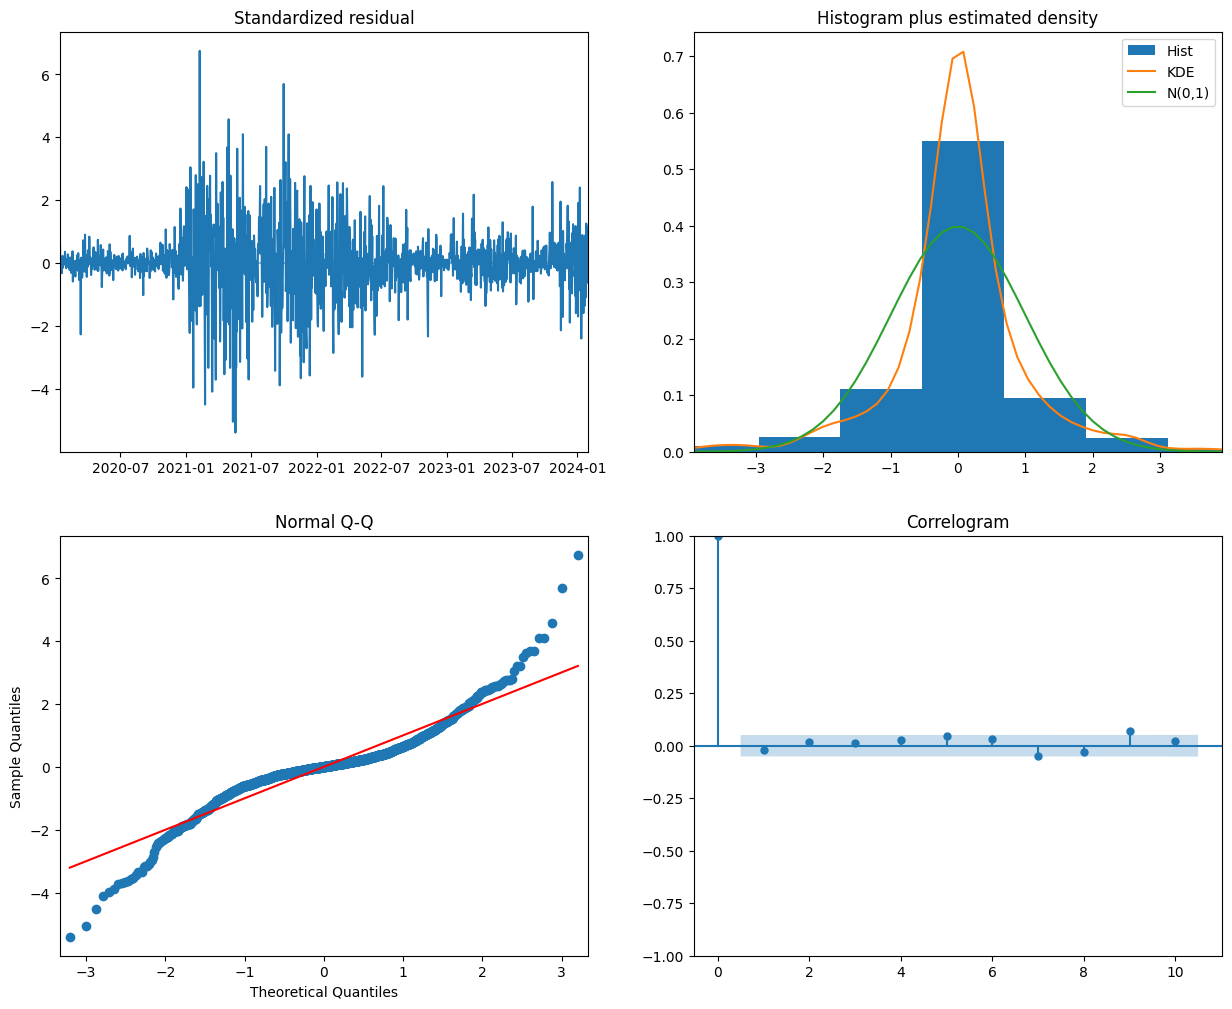

In [155]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [156]:
import pickle
# Serialize with Pickle and save it as pkl
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(sarima_model, pkl)

# Desiarilize the content of the file back into a Python object
with open('sarima_model.pkl', 'rb') as pkl:
    loaded_model = pickle.load(pkl)

In [157]:
def forecast(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

In [158]:
test=forecast(loaded_model, apple_transformed, '2024-02-05')

In [159]:
test

,Actual,Prediction,Low,High
2020-01-01,7200.174316,NaN,NaN,NaN
2020-01-02,6985.470215,NaN,NaN,NaN
2020-01-03,7344.884277,NaN,NaN,NaN
2020-01-04,7410.656738,NaN,NaN,NaN
2020-01-05,7411.317383,NaN,NaN,NaN
...,...,...,...,...
2024-02-01,NaN,44182.303729,41600.648458,46763.958999
2024-02-02,NaN,43572.351480,39981.107106,47163.595853
2024-02-03,NaN,43058.804235,38731.635650,47385.972821
2024-02-04,NaN,43068.191369,38151.557859,47984.824878


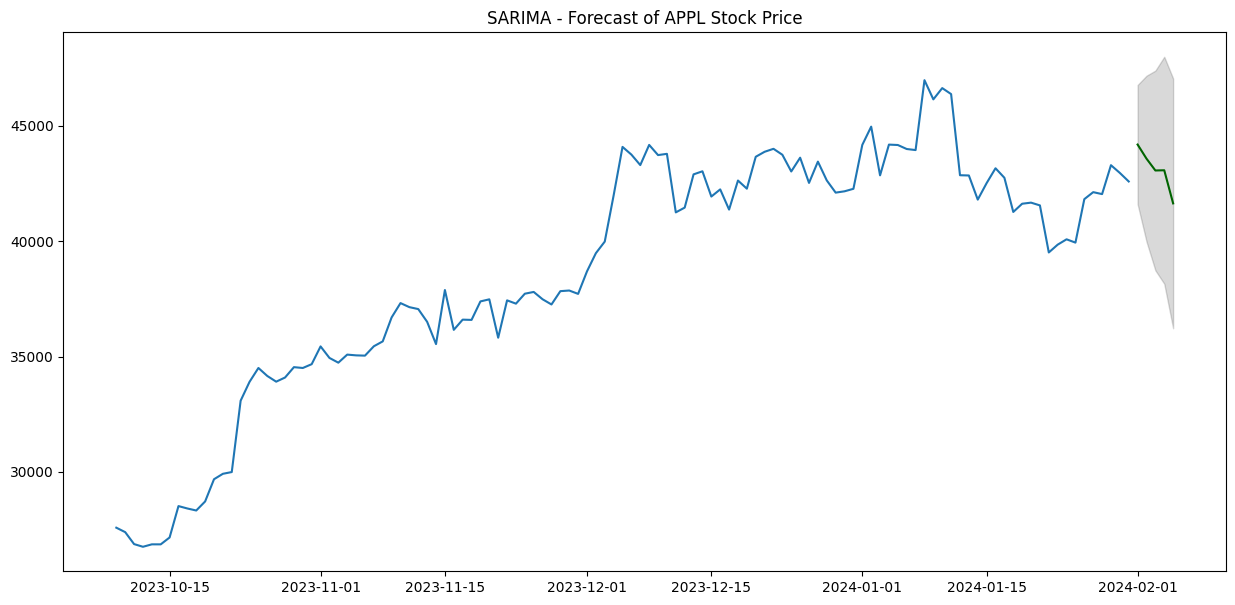

In [160]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(test["Actual"][-120:], color='#1f76b4')
plt.plot(test["Prediction"], color='darkgreen')
plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

plt.title("SARIMA - Forecast of APPL Stock Price")
plt.show()

LSTM MODEL:

In [161]:
apple_data = yf.download("BTC-USD", start = "2020-01-01", end = '2024-02-01', interval = '1d')
apple_df_test = apple_data.reset_index()
apple_df = apple_df_test.copy()

[*********************100%%**********************]  1 of 1 completed


In [162]:
scaler = MinMaxScaler()
data_transformed = pd.DataFrame(
    np.squeeze(
        scaler.fit_transform(
            apple_df[["Close"]])), columns=["Close"], index=apple_df.index)
#data_transformed["Date"] = (datetime)(apple_df["Date"])
#print(data_transformed)

In [163]:
def features_targets(data, feature_length):
    # feature length is the number of time steps in the input sequence
    # targets are the values the model is trying to forecast
    time_step_list, close_label_list = [], []
    
    # iterate through (length of sequential data) to (length of seq data - feature length)
    for i in range(len(data) - feature_length):
        # this will get the vals leading up to the target
        time_steps = data[i : i + feature_length]
        time_step_list.append(time_steps)
        # this will get the target val at this point
        labels = data[i + feature_length]
        close_label_list.append(labels)

    # reshape lists to be suitable for network algo
    time_step_list = np.array(time_step_list).reshape(len(time_step_list), feature_length, 1)
    close_label_list = np.array(close_label_list).reshape(len(close_label_list), 1)

    return time_step_list, close_label_list

In [164]:
time_step_vals, target_vals = features_targets(data_transformed["Close"].values, 20)

In [165]:
train_vals_cutoff = apple_df.loc[apple_df['Date'] >= '2022-01-01']
slice = train_vals_cutoff.shape[0]


In [166]:
def create_model(X, Y, df, data, train_test_slice, scaler):
    # training set: set to train the machine learning model
    # testing set: set used to test model after model has been trained
    # train set is 70% of data, test set is the rest (30%)
    X_train, X_test = X[:-train_test_slice], X[-train_test_slice:]
    Y_train, Y_test = Y[:-train_test_slice], Y[-train_test_slice:]

    # initialize empty model where nodes have input and output with Keras
    model = Sequential()
    # create a bidirectional LSTM: 
    # - 100 cells
    # - return output for input
    # - reduce overfitting w current dropout
    # - specify # of steps for target
    model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1, input_shape=(X_train.shape[1], 1))))
    # provide additional processing with undirectional layer
    model.add(LSTM(50, recurrent_dropout=0.1))
    # add dropout and dense layers
    # randomly sets 20% of inputs to 0 to prevent overfitting
    model.add(Dropout(0.2))
    # create a connected layer with 25 output units
    model.add(Dense(20, activation='elu'))
    model.add(Dropout(0.2))
    # create a connected layer with 10 output units
    model.add(Dense(10))
    # create a connected layer with 1 output unit
    model.add(Dense(1))

    # optimize model using stochastic gradient descent to train model
    # SGD 
    optimize = tf.keras.optimizers.SGD(learning_rate = 0.002)
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimize)
    # save model weights validation loss improves
    weights = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
    # adjust learning rate when needed
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=0.00001, verbose=1)

    # one epoch completes when the entire training dataset is processed once by the model
    model.fit(X_train, Y_train, epochs=12, batch_size=1, verbose=1, shuffle=False, validation_data=(X_test, Y_test), callbacks=[reduce_lr, weights])
    actual = scaler.inverse_transform(Y_test)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = np.squeeze(actual, axis=1)
    predictions = np.squeeze(predictions, axis=1)

    #reassign index before it goes into model
    test_df = pd.DataFrame({'Actual': actual, 'Predicted': predictions.flatten()})
    
    #print test_df plot
    '''
    # Plotting test set
    graph.plot(df.index[-train_test_slice:], predictions, label="Predicted")
    graph.plot(df.index[-train_test_slice:], actual, label="Actual")
    graph.xlabel('Date')
    graph.ylabel('Stock Price')
    graph.legend()
    graph.savefig('predicted_stock_prices_lstm3_test.png')
    graph.show()
    '''
    return model, X_train, X_test, Y_train, Y_test

In [167]:
# assign model, x training set, y training set, x testing set, and y testing set
lstm_model, X_train, X_test, Y_train, Y_test = create_model(
        time_step_vals, target_vals, apple_df, data_transformed["Close"].values, slice, scaler)

Epoch 1/12


711/711 [==============================] - 32s 38ms/step - loss: 0.0130 - val_loss: 0.0984 - lr: 0.0020
Epoch 2/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0169 - val_loss: 0.0801 - lr: 0.0020
Epoch 3/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0141 - val_loss: 0.0574 - lr: 0.0020
Epoch 4/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0114 - val_loss: 0.0564 - lr: 0.0020
Epoch 5/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0106 - val_loss: 0.0441 - lr: 0.0020
Epoch 6/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0094 - val_loss: 0.0321 - lr: 0.0020
Epoch 7/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0081 - val_loss: 0.0310 - lr: 0.0020
Epoch 8/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0073 - val_loss: 0.0198 - lr: 0.0020
Epoch 9/12
711/711 [==============================] - 26s 37ms/step - loss: 0.0073 - val_lo

In [168]:
# concatenate x sets, horiz axis
total_x = np.concatenate((X_train, X_test), axis = 0)
# concatenate y sets, horiz axis
total_y = np.concatenate((Y_train, Y_test), axis = 0)
# predict x axis with predict function
final_predict = lstm_model.predict(total_x)
# inverse transform x axis predictions
final_predict = scaler.inverse_transform(final_predict)
# inverse transform y predictions
actual = scaler.inverse_transform(total_y)
final_predict = np.squeeze(final_predict, axis = 1)
actual = np.squeeze(actual, axis = 1)

25/46 [===============>..............] - ETA: 0s

46/46 [==============================] - 1s 12ms/step


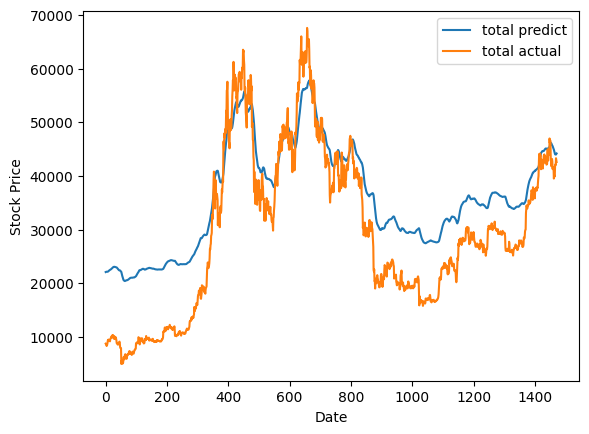

In [169]:
import matplotlib.pyplot as graph
graph.plot(final_predict, label = "total predict")
graph.plot(actual, label = "total actual")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [170]:
def predict_lstm(model, df, future_date, scaler, feature_length=20):
    # iterate through today's date until future date
    for i in range((datetime.strptime(future_date, '%Y-%m-%d') - df.index[-1]).days):
        # specify close values
        feature_column = df['Close'].values
        # pick out last 20 days
        time_steps = feature_column[-feature_length:]
        # reshape array
        time_steps = time_steps.reshape(feature_length, 1)
        # scale array
        time_steps = scaler.transform(time_steps)
        prediction = model.predict(time_steps.reshape(1, feature_length, 1))
        prediction = scaler.inverse_transform(prediction)
        # concatenate results with og dataframe
        predicted_vals = pd.DataFrame(prediction, index=[df.index[-1] + timedelta(days=1)], columns=['Close'])
        df = pd.concat([df, predicted_vals])
    return df

In [171]:
print(lstm_model.summary())
lstm_model.predict(data_transformed[-21:-1].values.reshape(1,20,1))
data = pd.DataFrame(apple_data)
test_lstm = predict_lstm(lstm_model, data, '2024-02-05', scaler)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 20, 200)           81600     
 onal)                                                           
                                                                 
 lstm_7 (LSTM)               (None, 50)                50200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                1020      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                      

/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [172]:
# print close values leading up to march 1st
test_lstm.tail(30)

,Open,High,Low,Close,Adj Close,Volume
2024-01-07,43998.464844,44495.570312,43662.230469,43943.097656,43943.097656,1.933057e+10
2024-01-08,43948.707031,47218.000000,43244.082031,46970.503906,46970.503906,4.274619e+10
2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,3.982129e+10
2024-01-10,46121.539062,47647.222656,44483.152344,46627.777344,46627.777344,5.011461e+10
2024-01-11,46656.074219,48969.371094,45678.644531,46368.585938,46368.585938,4.583373e+10
2024-01-12,46354.792969,46498.136719,41903.769531,42853.167969,42853.167969,4.333270e+10
2024-01-13,42799.445312,43234.660156,42464.144531,42842.382812,42842.382812,2.060186e+10
2024-01-14,42842.261719,43065.597656,41724.613281,41796.269531,41796.269531,1.752143e+10
2024-01-15,41715.066406,43319.722656,41705.417969,42511.968750,42511.968750,2.232022e+10
2024-01-16,42499.335938,43566.273438,42085.996094,43154.945312,43154.945312,2.406287e+10


                   Open         High          Low         Close    Adj Close  \
2020-01-01  7194.892090  7254.330566  7174.944336   7200.174316  7200.174316   
2020-01-02  7202.551270  7212.155273  6935.270020   6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094   7344.884277  7344.884277   
2020-01-04  7345.375488  7427.385742  7309.514160   7410.656738  7410.656738   
2020-01-05  7410.451660  7544.497070  7400.535645   7411.317383  7411.317383   
...                 ...          ...          ...           ...          ...   
2024-02-01          NaN          NaN          NaN  44249.062500          NaN   
2024-02-02          NaN          NaN          NaN  44426.566406          NaN   
2024-02-03          NaN          NaN          NaN  44614.960938          NaN   
2024-02-04          NaN          NaN          NaN  44809.894531          NaN   
2024-02-05          NaN          NaN          NaN  45002.769531          NaN   

                  Volume  
2020-01-01  

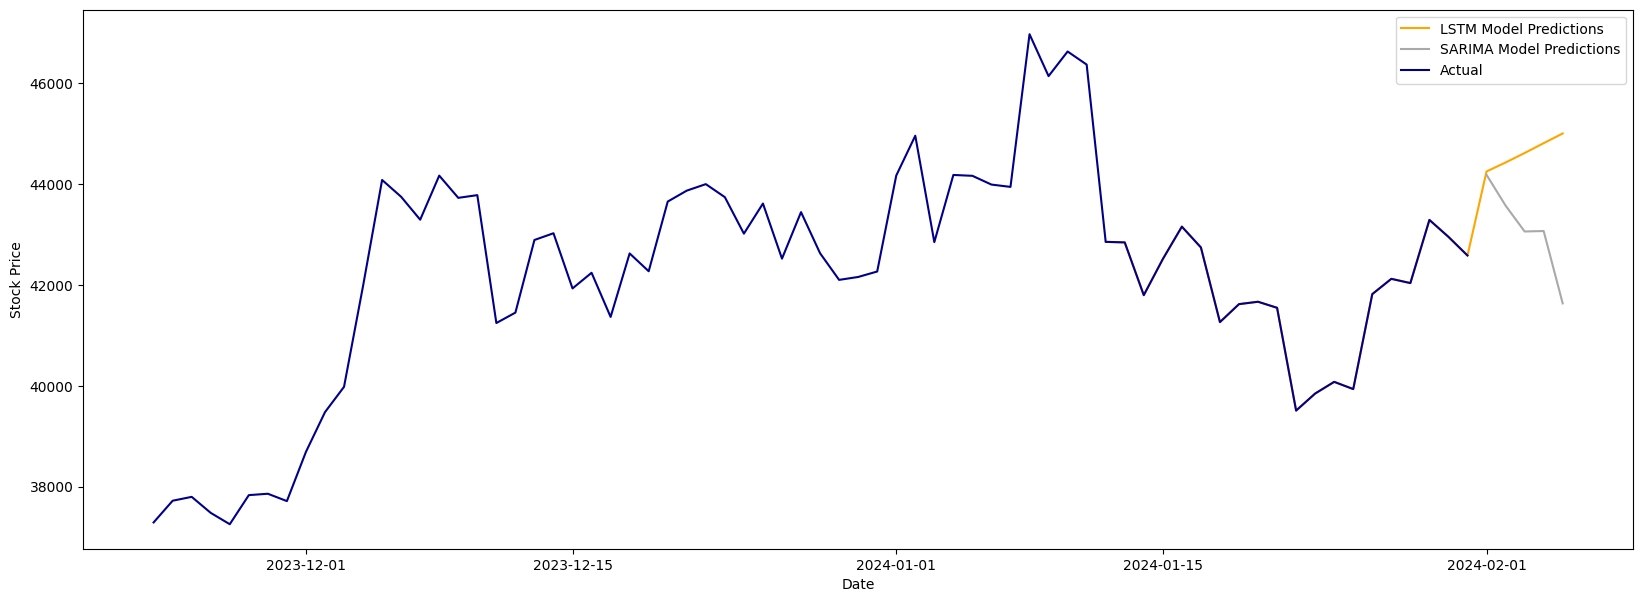

In [173]:
import matplotlib.pyplot as graph

print(test_lstm)
graph.figure(figsize=(20,7))
graph.plot((test_lstm["Close"][-25:]), label = "LSTM Model Predictions", color = 'orange')
#graph.plot(p, label = "LSTM Model Predictions", color = 'orange')
graph.plot(test["Prediction"][-25:], label = "SARIMA Model Predictions", color = 'darkgrey')
graph.plot(test["Actual"][-75:], label = "Actual", color = 'darkblue')
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
#graph.size((12,7))

graph.savefig('test.png')
graph.show()


In [174]:

def forecasting(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

def combined_model(data_transformed, lstm_model, sarima_model, forecast_date, scaler):

  #print(data_transformed.tail())
  # create dataframes for high and low values
  df_high = pd.DataFrame(columns=['High'])
  df_low = pd.DataFrame(columns=['Low'])
  #last_initial_date = data_transformed.index[-1]
  # create variable referring to last day
  last_day = data_transformed.index[-1]
  #print(last_day)
  


  # iterate through the number of days between last day and future date
  for i in range((datetime.strptime(forecast_date, '%Y-%m-%d') - data_transformed.index[-1]).days):
    # call prediction function for lstm
    df_lstm_temp = predict_lstm(lstm_model, data_transformed, (data_transformed.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d'), scaler)
    #print(df_lstm_temp.tail())
    # call forecast function for sarima
    df_sarima_temp = forecasting(sarima_model, data_transformed, (data_transformed.index[-1] + timedelta(days=i+1)).strftime('%Y-%m-%d'))
    #print(df_sarima_temp.tail())


    # combine 40% of lstm results and 60% of sarima results for closing vals on last day (day to predict)
    #combination = 0.4 * (scaler.transform(df_lstm_temp.iloc[-1]['Close'].reshape(1,-1))) + 0.6 * (scaler.transform(df_sarima_temp.iloc[-1]['Prediction'].reshape(1,-1)))
    combination = 0.2 * (scaler.transform(test_lstm.iloc[-1]['Close'].reshape(-1,1))) + 0.8 * (scaler.transform(df_sarima_temp.iloc[-1]['Prediction'].reshape(-1,1)))
    print(combination)

    # create new dataframe of combo :D
    forecast = pd.DataFrame(combination, index = [data_transformed.index[-1] + timedelta(days=1)], columns = ['Close'])
    data_transformed = pd.concat([data_transformed, forecast])
    # create new dataframe of low values
    df_low = pd.concat([df_low, pd.DataFrame(df_sarima_temp.iloc[-1]['Low'],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=['Low'])
    ])
    # create new dataframe of high values
    df_high = pd.concat([df_high, pd.DataFrame(df_sarima_temp.iloc[-1]['High'],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=['High'])
    ])

  # squeeze final results to one axis, and inverse transform
  df_final = pd.DataFrame(np.squeeze(scaler.inverse_transform(data_transformed)),
                        index=data_transformed.index, columns=['Close'])

  #print(df_final.tail())

  # final actual df values are all days leading up to last day that has occurred
  df_final_actual = df_final[:last_day + timedelta(days=1)]
  # final predicted df values are all future days
  df_final_prediction = df_final[last_day + timedelta(days=1):]
  print(df_final_prediction.tail())

  return df_final_actual, df_final_prediction, df_low,  df_high



In [175]:
# get ~final~ combined results
combined_actual, combined_prediction, combined_df_low, combined_df_high = combined_model(apple_transformed, lstm_model, sarima_model, '2024-02-05', scaler)

1/1 [==============================] - 0s 27ms/step
[[0.62904313]]
1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_1287/2979405428.py:55: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_low = pd.concat([df_low, pd.DataFrame(df_sarima_temp.iloc[-1]['Low'],
/tmp/ipykernel_1287/2979405428.py:55: FutureWarning: The behavior

[[0.62124772]]
1/1 [==============================] - 0s 26ms/step
[[0.6146844]]
1/1 [==============================] - 0s 27ms/step
[[0.61480437]]
1/1 [==============================] - 0s 26ms/step


[[0.59646604]]
                   Close
2024-02-01  44346.396889
2024-02-02  43858.435090
2024-02-03  43447.597295
2024-02-04  43455.107001
2024-02-05  42307.200103


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465

In [176]:
print(combined_actual.tail())

                   Close
2024-01-28  42035.593750
2024-01-29  43288.246094
2024-01-30  42952.609375
2024-01-31  42582.605469
2024-02-01  44346.396889


In [177]:
print(combined_prediction.tail())

                   Close
2024-02-01  44346.396889
2024-02-02  43858.435090
2024-02-03  43447.597295
2024-02-04  43455.107001
2024-02-05  42307.200103


In [3]:
import pandas as pd
import matplotlib.pyplot as graph 
actual = pd.dataframe(a)

graph.figure(figsize=(12,5))
graph.plot(combined_actual[-40:], color='#1f76b4', label = "Actual")
#graph.plot(combined_prediction[-40:], color='black', label = "SARIMA Model Predictions")
#UNCOMMENT BELOW
graph.plot(combined_prediction, color='green', label = "Combined Prediction")

#graph.plot(test["Prediction"][-7:], label = "Combined Prediction", color = 'green')
#UNCOMMENT BELOW
graph.plot(test["Prediction"][-7:], label = "SARIMA Model Predictions", color = 'black')
graph.plot((test_lstm["Close"][-5:]), label = "LSTM Model Predictions", color = 'purple')
#graph.plot(test["Actual"][-75:], color = 'darkblue')
graph.legend()
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.title("Bitcoin Prediction 02-05-2024")
graph.show()

print(test.tail())
print(test_lstm.tail())
print(combined_actual.tail())
print(combined_prediction.tail())
print()

AttributeError: module 'pandas' has no attribute 'dataframe'

In [179]:

# specify google cloud project information
dataset_id = 'predicted_prices'
table_id = 'SARIMA and LTSM Predicted Prices'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
# enter combined data load_data = client.load_table_from_dataframe(combined data, table_path, job_config=load_info)
load_data.result()

LoadJob<project=black-vehicle-406619, location=US, id=edabeaae-f6c4-44fe-8c1a-fffe128f1cdd>